In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/laidd_신약개발머신러닝2023

/content/drive/MyDrive/laidd_신약개발머신러닝2023


In [ ]:
# !pip install deepchem
import deepchem as dc

In [4]:
dc.__version__

'2.7.1'

In [5]:
import pandas as pd
import  numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [6]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit import DataStructs
import tensorflow as tf

from deepchem.feat.mol_graphs import ConvMol
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
from deepchem.models.graph_models import GraphConvModel

from deepchem.metrics import to_one_hot
from deepchem.utils.data_utils import load_from_disk
import tensorflow.keras.layers as layers

In [7]:
from deepchem.feat.mol_graphs import ConvMol
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
from deepchem.models.graph_models import GraphConvModel

In [8]:
data_path = "./data/preprocessed_data.csv"
df = pd.read_csv(data_path)
df.head()

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43


In [9]:
df_X = df.drop(["MLM", "HLM"], axis=1)
y_MLM = df['MLM']
y_HLM = df['HLM']

In [10]:
### 데이터 전처리

In [11]:
## 표현형을 그래프 표현형인 ConvMol로 선택해보기
featurizer = dc.feat.ConvMolFeaturizer()

In [12]:
## 데이터 로더로  X, y 표현형 등을 정의
loader_HLM = dc.data.CSVLoader(tasks = ["HLM"], feature_field='SMILES', featurizer=featurizer)
loader_MLM = dc.data.CSVLoader(tasks = ["MLM"], feature_field='SMILES', featurizer=featurizer)
# test_HLM = dc.data.CSVLoader(tasks = ["HLM"], feature_field='SMILES', featurizer=featurizer)
# test_MLM = dc.data.CSVLoader(tasks = ["MLM"], feature_field='SMILES', featurizer=featurizer)

In [13]:
dataset_HLM = loader_HLM.create_dataset('./data/preprocessed_data.csv')
dataset_MLM = loader_MLM.create_dataset('./data/preprocessed_data.csv')

In [14]:
test_df = pd.read_csv("./data/test.csv")
test_df.head()

,id,SMILES,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TEST_000,CC(C)Nc1ccnc(N2CCN(Cc3cccs3)C(CCO)C2)n1,2.641,361.505,4,2,7,2.635,92.76
1,TEST_001,COc1cc(=O)n(-c2ccccc2)cc1C(=O)N1CCC2(CC1)OCCO2,0.585,370.399,5,0,3,0.585,68.31
2,TEST_002,Cc1cccc(NC(=N)/N=c2\nc(O)c(Cc3ccccc3)c(C)[nH]2)c1,4.276,347.414,4,4,5,4.290,92.86
3,TEST_003,O=C(c1nc2ncccn2n1)N1CCCn2cc(-c3ccccc3)nc21,1.795,345.358,5,0,2,1.795,81.21
4,TEST_004,CCN1CCN(C(=O)c2cc3c(=O)n4cc(C)ccc4nc3n2C)CC1,1.219,353.418,4,0,2,0.169,61.15


In [15]:
test_HLM = dc.data.CSVLoader(tasks = ["Num_H_Donors"], feature_field='SMILES', featurizer=featurizer)
test_dataset = test_HLM.create_dataset('./data/test.csv')
len(test_dataset)

483

In [16]:
dataset_HLM.X.shape, dataset_MLM.X.shape

((3487,), (3487,))

In [17]:
## splitter 선택
splitter = dc.splits.RandomSplitter()

# train_dataset_HLM, valid_dataset_HLM, test_dataset_HLM = splitter.train_valid_test_split(dataset_HLM)
# train_dataset_MLM, valid_dataset_MLM, test_dataset_MLM = splitter.train_valid_test_split(dataset_MLM)


train_dataset_HLM, valid_dataset_HLM = splitter.train_test_split(dataset_HLM)
train_dataset_MLM, valid_dataset_MLM = splitter.train_test_split(dataset_MLM)

In [18]:
len(train_dataset_HLM)

2789

In [19]:
from tqdm import tqdm

In [20]:
from deepchem.models.graph_models import GraphConvModel

In [37]:
import tensorflow as tf
from tensorflow.keras import layers
from deepchem.models.layers import GraphConv, GraphPool, GraphGather


class GraphConvBlock(tf.keras.layers.Layer):
    def __init__(self, hidden_dim, dropout_rate):
        super(GraphConvBlock, self).__init__()
        self.gc = GraphConv(hidden_dim)
        self.dropout = layers.Dropout(dropout_rate)
        self.batch_norm = layers.BatchNormalization()
        self.activation_fn = tf.keras.activations.relu
        self.gp = GraphPool()

    def call(self, inputs):
        gc_output = self.gc(inputs)
        dropout_output = self.dropout(gc_output)
        batch_norm_output = self.batch_norm(dropout_output)
        activation_output = self.activation_fn(batch_norm_output)

        gp_output = self.gp([activation_output] + inputs[1:])

        return gp_output


class MyGraphConvModel(tf.keras.Model):

    def __init__(self):
        super(MyGraphConvModel, self).__init__()

## transformer 모델처럼 멀티헤드로
        self.graph_conv_block1 = GraphConvBlock(256, 0.2)
        self.graph_conv_block2 = GraphConvBlock(256, 0.2)
        self.graph_conv_block3 = GraphConvBlock(256, 0.2)

        self.graph_conv_block4 = GraphConvBlock(256, 0.2)
        self.graph_conv_block5 = GraphConvBlock(256, 0.2)
        self.graph_conv_block6 = GraphConvBlock(256, 0.2)

# 초기 레이어 결과값

# 1헤드 graph 정보 저장
        self.dense1 = layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0001, l2=0.0001))
        self.dropout1 = layers.Dropout(0.5)
        self.batch_norm1 = layers.BatchNormalization()
        self.activation1 = tf.keras.activations.relu

# 2헤드 graph 정보 저장
        self.dense2 = layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0001, l2=0.0001))
        self.dropout2 = layers.Dropout(0.5)
        self.batch_norm2 = layers.BatchNormalization()
        self.activation2 = tf.keras.activations.relu

# 초기 graph 정보 저장
        # self.dense0 = layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0001, l2=0.0001))
        # self.dropout0 = layers.Dropout(0.5)
        # self.batch_norm0 = layers.BatchNormalization()
        # self.activation0 = tf.keras.activations.relu


        self.readout1 = GraphGather(batch_size=batch_size, activation_fn=tf.nn.relu)
        self.readout2 = GraphGather(batch_size=batch_size, activation_fn=tf.nn.relu)


        self.dense_last_1 = layers.Dense(256,
                                        #  activation=tf.nn.relu,
                                        #  kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0001, l2=0.0001)
                                         )
        self.dense_last_2 = layers.Dense(256,
                                        #  activation=tf.nn.relu,
                                        #  kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0001, l2=0.0001)
                                         )

        self.fclayer1 = layers.Dense(512,
                                    #  activation=tf.nn.relu,
                                    #  kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0001, l2=0.0001)
                                     )
        self.fclayer2 = layers.Dense(512,
                                    #  activation=tf.nn.relu,
                                    #  kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0001, l2=0.0001)
                                     )

        self.logits = layers.Dense(1,
                                #    activation=tf.keras.layers.LeakyReLU(alpha=0.2)
                                   )

    def call(self, inputs):
        # 헤드1 -> 병렬
        gp1_output = self.graph_conv_block1(inputs)
        gp2_output = self.graph_conv_block2([gp1_output] + inputs[1:])
        gp3_output = self.graph_conv_block3([gp2_output] + inputs[1:])

        dense1_output = self.dense1(gp3_output)
        batch_norm1_out = self.batch_norm1(dense1_output)
        activation1_out = self.activation1(batch_norm1_out)
        dropout1_out = self.dropout1(activation1_out)

        readout_output1 = self.readout1([dropout1_out] + inputs[1:])
        dense_last_1_output = self.dense_last_1(readout_output1)

        # 헤드2 -> 병렬
        gp4_output = self.graph_conv_block4(inputs)
        gp5_output = self.graph_conv_block5([gp4_output] + inputs[1:])
        gp6_output = self.graph_conv_block5([gp5_output] + inputs[1:])

        dense2_output = self.dense2(gp6_output)
        batch_norm2_out = self.batch_norm2(dense2_output)
        activation2 = self.activation2(batch_norm2_out)
        dropout2_out = self.dropout2(activation2)

        readout_output2 = self.readout2([dropout2_out] + inputs[1:])
        dense_last_2_output = self.dense_last_2(readout_output2)


        # 초기 graph 결과


    ## 최종 결과
        concatenated_output = tf.concat([dense_last_1_output,
                                         dense_last_2_output,
                                        #  dense_last_0_output
                                         ], axis=-1)

        fclayer1_out = self.fclayer1(concatenated_output)
        fclayer2_out = self.fclayer2(fclayer1_out)

        logits_output = self.logits(fclayer2_out)

        return logits_output


In [36]:
def data_generator(dataset, epochs, batch_size):
    for ind, (X_b, y_b, w_b, ids_b) in enumerate(dataset.iterbatches(batch_size, epochs, deterministic=False, pad_batches=True)):
        multiConvMol = ConvMol.agglomerate_mols(X_b)
        inputs = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
        for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
            inputs.append(multiConvMol.get_deg_adjacency_lists()[i])
        labels = [y_b]
        weights = [w_b]
        yield (inputs, labels, weights)

In [23]:
from deepchem.models.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

In [24]:
learning_rate= 0.01
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.01,
#     decay_steps=10000,
#     decay_rate=0.9)
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

metric1 = dc.metrics.Metric(dc.metrics.mean_squared_error)
optimizer = Adam(learning_rate=0.01, beta1=0.9, beta2=0.999)

In [ ]:
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

In [25]:
import matplotlib.pyplot as plt
def plot_graph(loss_list, val_loss_list):
    # 손실(loss) 그래프
    plt.plot(loss_list, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')

    # 검증 손실(validation loss) 그래프
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()
    plt.show()

In [39]:
epochs = 20
batch_size = 16

## 최종 실행 MLM 모델
gcn_model_MLM = dc.models.KerasModel(MyGraphConvModel(),
                                     optimizer=optimizer,
                                     loss=tf.keras.losses.MeanSquaredError(),
#  tensorboard=True,
                                     verbose=True,
                                     metric=['mse'],
                                     model_dir="./MLM_last2",
                                     batch_size = batch_size,
                                     save_checkpoint=1)

min_val_loss = 3000
min_loss = 3000
MLM_val_loss_list = []
MLM_loss_list = []

for x in range(epochs):
    loss = gcn_model_MLM.fit_generator(data_generator(train_dataset_MLM, epochs=1, batch_size = batch_size))
    MLM_loss_list.append(loss)
    val_loss = gcn_model_MLM.evaluate_generator(data_generator(valid_dataset_MLM, epochs=1, batch_size = batch_size), metrics=[metric1])
    val_loss = val_loss['mean_squared_error']
    MLM_val_loss_list.append(val_loss)
    if loss < min_loss:
        min_loss = loss

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        print(f"epochs : {x} ------ changed !! loss : {loss}  // val_loss : {val_loss} //  min_val_loss : {min_val_loss}: ")
    else:
        print(f"epochs : {x} ------ loss : {loss}  // val_loss : {val_loss} //  min_val_loss : {min_val_loss}: ")
    if abs(val_loss - min_val_loss) < 100:
        if abs(min_loss - loss) < 100:
            print(f"saved result_gcn_model : loss : {loss}, val_loss : {val_loss}")
            result_gcn_model_MLM = gcn_model_MLM

epochs : 0 ------ loss : 22398.661666666667  // val_loss : 10546.593579439572 //  min_val_loss : 3000: 
epochs : 1 ------ changed !! loss : 4341.763125  // val_loss : 1384.6598322612756 //  min_val_loss : 1384.6598322612756: 
epochs : 2 ------ loss : 1385.73828125  // val_loss : 1426.2512505439038 //  min_val_loss : 1384.6598322612756: 
saved result_gcn_model : loss : 1385.73828125, val_loss : 1426.2512505439038
epochs : 3 ------ loss : 1545.0290625  // val_loss : 1404.0691908136812 //  min_val_loss : 1384.6598322612756: 
epochs : 4 ------ loss : 1444.9901041666667  // val_loss : 1456.028723612136 //  min_val_loss : 1384.6598322612756: 
saved result_gcn_model : loss : 1444.9901041666667, val_loss : 1456.028723612136
epochs : 5 ------ loss : 1967.718125  // val_loss : 7228.699451016699 //  min_val_loss : 1384.6598322612756: 
epochs : 6 ------ loss : 1386.51109375  // val_loss : 1399.7937807935223 //  min_val_loss : 1384.6598322612756: 
saved result_gcn_model : loss : 1386.51109375, val_

In [ ]:
result_gcn_model_MLM.model.save_weights("./data/result_gcn_model_MLM_weights_2.h5")
plot_graph(MLM_loss_list, MLM_val_loss_list)

In [ ]:
gcn_model_MLM.restore()

In [ ]:
### 추가 학습 코드
# for x in range(10):
#     loss = result_gcn_model_MLM.fit_generator(data_generator(train_dataset_MLM, epochs=1))
#     loss_list.append(loss)
#     val_loss = result_gcn_model_MLM.evaluate_generator(data_generator(valid_dataset_MLM, epochs=1), metrics=[metric1])
#     val_loss = val_loss['mean_squared_error']
#     val_loss_list.append(val_loss)

#     if val_loss < min_val_loss:
#         min_val_loss = val_loss
#         result_gcn_model_MLM2 = result_gcn_model_MLM
#         print(f"epochs : {x} ------ changed !! loss : {loss}  // val_loss : {val_loss} //  min_val_loss : {min_val_loss}: ")
#     else:
#         print(f"epochs : {x} ------ loss : {loss}  // val_loss : {val_loss} //  min_val_loss : {min_val_loss}: ")
#     if abs(val_loss - min_val_loss) < 50:
#         result_gcn_model_MLM = gcn_model_MLM

In [ ]:
# result_gcn_model_MLM2.model.save_weights("./data/result_gcn_model_MLM2_weights.h5")
# plot_graph(loss_list, val_loss_list)

In [ ]:
epochs = 1000
## 최종 실행 HLM 모델
gcn_model_HLM = dc.models.KerasModel(MyGraphConvModel(),
                                 optimizer=optimizer,
                                 loss=tf.keras.losses.MeanSquaredError(),
                                #  tensorboard=True,
                                 verbose=True,
                                 metric=['mse'],
                                 model_dir="./HLM_last",
                                 save_checkpoint=1)
min_val_loss = 3000
min_loss = 3000
val_loss_list = []
loss_list = []

for x in range(epochs):
    loss = gcn_model_HLM.fit_generator(data_generator(train_dataset_HLM, epochs=1))
    loss_list.append(loss)
    val_loss = gcn_model_HLM.evaluate_generator(data_generator(valid_dataset_HLM, epochs=1), metrics=[metric1])
    val_loss = val_loss['mean_squared_error']
    val_loss_list.append(val_loss)
    if loss < min_loss:
        min_loss = loss
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        print(f"epochs : {x} ------ changed !! loss : {loss}  // val_loss : {val_loss} //  min_val_loss : {min_val_loss}: ")
    else:
        print(f"epochs : {x} ------ loss : {loss}  // val_loss : {val_loss} //  min_val_loss : {min_val_loss}: ")
    if abs(val_loss - min_val_loss) < 100:
        if abs(min_loss -loss) < 100:
            result_gcn_model_HLM = gcn_model_HLM
            print('save model!!!')

epochs : 0 ------ changed !! loss : 3335.943181818182  // val_loss : 1295.7530547323643 //  min_val_loss : 1295.7530547323643: 
epochs : 1 ------ changed !! loss : 1235.8686266447369  // val_loss : 1253.9646866685346 //  min_val_loss : 1253.9646866685346: 
epochs : 2 ------ loss : 1197.90478515625  // val_loss : 1357.3526667075678 //  min_val_loss : 1253.9646866685346: 
epochs : 3 ------ loss : 1224.9690504807693  // val_loss : 1319.270370142418 //  min_val_loss : 1253.9646866685346: 
epochs : 4 ------ changed !! loss : 1202.2259765625  // val_loss : 1249.433612624272 //  min_val_loss : 1249.433612624272: 
epochs : 5 ------ loss : 1115.5587332589287  // val_loss : 1416.8532325266453 //  min_val_loss : 1249.433612624272: 
epochs : 6 ------ loss : 1077.3572998046875  // val_loss : 1313.300512479183 //  min_val_loss : 1249.433612624272: 
epochs : 7 ------ loss : 1082.919677734375  // val_loss : 1581.1938333353353 //  min_val_loss : 1249.433612624272: 
epochs : 8 ------ loss : 1141.0678267

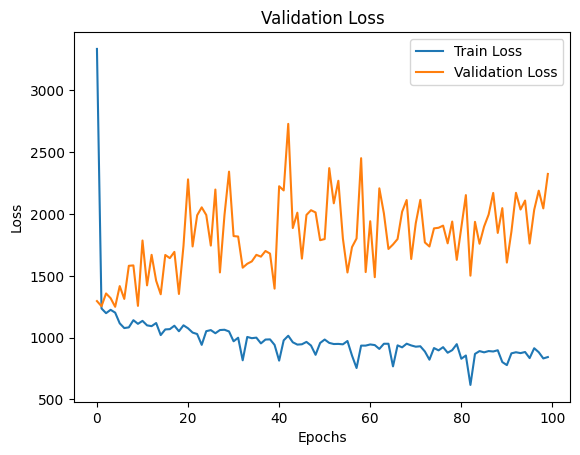

In [ ]:
result_gcn_model_HLM.model.save_weights("./data/result_gcn_model_HLM_weights.h5")
plot_graph(loss_list, val_loss_list)

In [ ]:
result_df = pd.read_csv("./data/sample_submission.csv")
result_df.head()

,id,MLM,HLM
0,TEST_000,0,0
1,TEST_001,0,0
2,TEST_002,0,0
3,TEST_003,0,0
4,TEST_004,0,0


In [ ]:
## 최종 예측 결과 저장
MLM_list = []
tmp = result_gcn_model_MLM.predict_on_generator(data_generator(test_dataset, epochs=1))
MLM_list = [x[0] for x in tmp]
MLM_list = MLM_list[:483]
# print(MLM_list)
print(len(MLM_list))

result_df['MLM'] = MLM_list
result_df.head()

483


,id,MLM,HLM
0,TEST_000,3.643900,0
1,TEST_001,3.643900,0
2,TEST_002,10.632557,0
3,TEST_003,12.305541,0
4,TEST_004,10.304384,0


In [ ]:
HLM_list = []
tmp = result_gcn_model_MLM.predict_on_generator(data_generator(test_dataset, epochs=1))
HLM_list = [x[0] for x in tmp]
HLM_list = HLM_list[:483]
# print(MLM_list)
print(len(HLM_list))

result_df['HLM'] = HLM_list
result_df.head()

483


,id,MLM,HLM
0,TEST_000,3.643900,7.308432
1,TEST_001,3.643900,27.556757
2,TEST_002,10.632557,70.817772
3,TEST_003,12.305541,10.966322
4,TEST_004,10.304384,3.643900


In [ ]:
result_df.to_csv("./data/last_result.csv", encoding="utf-8-sig", index=False)

In [ ]:
df_ = pd.read_csv("./data/last_result.csv")
df_.head(20)

,id,MLM,HLM
0,TEST_000,3.643900,7.308432
1,TEST_001,3.643900,27.556757
2,TEST_002,10.632557,70.817770
3,TEST_003,12.305541,10.966322
4,TEST_004,10.304384,3.643900
5,TEST_005,27.141966,34.732914
6,TEST_006,20.427916,50.610302
7,TEST_007,65.120230,10.024645
8,TEST_008,20.990767,32.303000
9,TEST_009,24.521826,26.733511


In [ ]:
df_[df_['HLM'] == 0]

,id,MLM,HLM


In [ ]:
df_[df_['MLM'] == 0]

,id,MLM,HLM


In [ ]:
df_[df_['MLM'] >100]

,id,MLM,HLM


In [ ]:
df_[df_['HLM'] > 100]

,id,MLM,HLM
